In [1]:
from dsc80_utils import *

In [2]:
salaries = pd.read_csv('https://transcal.s3.amazonaws.com/public/export/san-diego-2021.csv')
salaries['Employee Name'] = salaries['Employee Name'].str.split().str[0] + ' Xxxx'

jobtitles = salaries['Job Title']
jobtitles = jobtitles[jobtitles.notna()]
jobtitles = (
    jobtitles
    .str.lower()
    .str.replace(r'\bto\b|\bthe\b|\bfor\b', '', regex=True)
    .str.replace('[^A-Za-z0-9 ]', ' ', regex=True)
    .str.replace(' +', ' ', regex=True)               # ' +' matches 1 or more occurrences of a space.
    .str.strip()                                      # Removes leading/trailing spaces if present.
)

unique_words = pd.Series(jobtitles.str.split().sum()).value_counts()

# Created using a dictionary to avoid a "DataFrame is highly fragmented" warning.
counts_dict = {}
for word in unique_words.index:
    re_pat = fr'\b{word}\b'
    counts_dict[word] = jobtitles.str.count(re_pat).astype(int).tolist()
    
counts_df = pd.DataFrame(counts_dict).set_index(jobtitles)

# Lecture 12 – Text Features

## DSC 80, Fall 2023

## 📣 Announcements 📣

- Project 3 due Friday.
- Lab 7 out, due Monday, Nov 20.
- 116 / 153 = 76% of students filled out the Mid-quarter survey. Thanks for your responses!

## 📆 Agenda

- [ ] Bag of words
- [ ] Cosine similarity
- [ ] TF-IDF
    - [ ] Example: State of the Union addresses 🎤.

## 📝 Mid-Quarter Survey

- Overall high satisfaction with the course so far.
    - Higher workload, but not beyond what we expected going in.
- Assignment wordings could be more clear (e.g. Lab 4).
    - We have a long list of changes we want to make to assignments based on your feedback during OH, we're working on improving the assignments for next quarter.
- 25% of class can't attend any scheduled OH.
    - Will ask staff to see whether other times are available.
- Lecture pace is fast!
    - DSC 80 covers a LOT of material.
    - I'll walk through more small examples, and sketch out approach to code
    - I'll include a Slido for every lecture for Q&A, send questions to slow me down!

## 🙋🙋🏽‍♀️ Slido

https://app.sli.do/event/2LZSnXWNpGPiuVnCZMa5J8

<center><img src="imgs/slido.svg" width="30%"></center>




## Bag of words 💰

### Example: San Diego employee salaries

Recall, we're working with a (real) dataset of salary data for all San Diego city employees.

In [3]:
jobtitles

0                  city attorney
1                          mayor
2             investment officer
                  ...           
12302               fire captain
12303    fleet repair supervisor
12304              fire engineer
Name: Job Title, Length: 12303, dtype: object

### Text similarity

Recall, our idea is to measure the similarity of two job titles by counting the number of shared words between the job titles. How do we actually do that, for all of the job titles we have?

### A counts matrix

Let's create a "counts" matrix, such that:
- there is 1 row per job title,
- there is 1 column per **unique** word that is used in job titles, and
- the value in row `title` and column `word` is the number of occurrences of `word` in `title`.

Such a matrix might look like:

| | senior | lecturer | teaching | professor | assistant | associate |
| --- | --- | --- | --- | --- | --- | --- |
| **senior lecturer** | 1 | 1 | 0 | 0 | 0 | 0 |
| **assistant teaching professor** | 0 | 0 | 1 | 1 | 1 | 0 | 
| **associate professor** | 0 | 0 | 0 | 1 | 0 | 1 |
| **senior assistant to the assistant professor** | 1 | 0 | 0 | 1 | 2 | 0 |

### Creating a counts matrix

First, we need to determine all words that are used across all job titles.

In [4]:
jobtitles.str.split()

0                   [city, attorney]
1                            [mayor]
2              [investment, officer]
                    ...             
12302                [fire, captain]
12303    [fleet, repair, supervisor]
12304               [fire, engineer]
Name: Job Title, Length: 12303, dtype: object

In [5]:
# The .explode method concats the lists together
all_words = jobtitles.str.split().explode()
all_words

0              city
0          attorney
1             mayor
            ...    
12303    supervisor
12304          fire
12304      engineer
Name: Job Title, Length: 33304, dtype: object

Next, to determine the columns of our matrix, we need to find a list of all **unique** words used in titles. We can do this with `np.unique`, but `value_counts` shows us the distribution, which is interesting.

In [7]:
unique_words = all_words.value_counts()
unique_words

officer      2343
ii           2305
police       2294
             ... 
utilities       1
gardener        1
principle       1
Name: Job Title, Length: 327, dtype: int64

Note that in `unique_words.index`, job titles are sorted by number of occurrences!

For each of the 327 unique words that are used in job titles, we can count the number of occurrences of the word in each job title.
- `'deputy fire chief'` contains the word `'deputy'` once, the word `'fire'` once, and the word `'chief'` once.
- `'assistant managers assistant'` contains the word `'assistant'` twice and the word `'managers'` once.

In [8]:
# Created using a dictionary to avoid a "DataFrame is highly fragmented" warning.
counts_dict = {}
for word in unique_words.index:
    re_pat = fr'\b{word}\b'
    counts_dict[word] = jobtitles.str.count(re_pat).astype(int).tolist()
    
counts_df = pd.DataFrame(counts_dict)

In [9]:
counts_df.head()

,officer,ii,police,i,...,geologist,utilities,gardener,principle
0,0,0,0,0,...,0,0,0,0
1,0,0,0,0,...,0,0,0,0
2,1,0,0,0,...,0,0,0,0
3,1,0,1,0,...,0,0,0,0
4,0,0,0,0,...,0,0,0,0


`counts_df` has one row for all 12303 employees, and one column for each unique word that is used in a job title.

In [10]:
counts_df.shape

(12303, 327)

To put into context what the numbers in `counts_df` mean, we can show the actual job title for each row.

In [11]:
counts_df = counts_df.set_index(jobtitles)
counts_df.head()

,officer,ii,police,i,...,geologist,utilities,gardener,principle
Job Title,,,,,,,,,
city attorney,0,0,0,0,...,0,0,0,0
mayor,0,0,0,0,...,0,0,0,0
investment officer,1,0,0,0,...,0,0,0,0
police officer,1,0,1,0,...,0,0,0,0
independent budget analyst,0,0,0,0,...,0,0,0,0


The fourth row tells us that the fourth job title contains `'police'` once and `'officer'` once.

### Interpreting the counts matrix

In [12]:
counts_df.head()

,officer,ii,police,i,...,geologist,utilities,gardener,principle
Job Title,,,,,,,,,
city attorney,0,0,0,0,...,0,0,0,0
mayor,0,0,0,0,...,0,0,0,0
investment officer,1,0,0,0,...,0,0,0,0
police officer,1,0,1,0,...,0,0,0,0
independent budget analyst,0,0,0,0,...,0,0,0,0


The Series below describes the 20 most common words used in job titles, along with the number of times they appeared in all job titles (including repeats). We will call these words "top 20" words.

In [13]:
# Remember, the columns of counts_df are ordered by number of occurrences.
counts_df.iloc[:, :20].sum()

officer       2343
ii            2305
police        2294
              ... 
operator       380
recreation     371
supervisor     362
Length: 20, dtype: int64

The Series below describes the **number of top 20 words** used in each job title.

In [14]:
counts_df.iloc[:, :20].sum(axis=1)

Job Title
city attorney              0
mayor                      0
investment officer         1
                          ..
fire captain               1
fleet repair supervisor    1
fire engineer              2
Length: 12303, dtype: int64

### Question: What job titles are most similar to `'deputy fire chief'`?

- Remember, our idea was to count the number of shared words between two job titles.

- We now have access to `counts_df`, which contains a row vector for each job title.

- How can we use it to count the number of shared words between two job titles, i.e. the **similarity** of two job titles?

To start, let's compare the row vectors for `'deputy fire chief'` and `'fire battalion chief'`.

In [15]:
dfc = counts_df.loc['deputy fire chief'].iloc[0]
dfc

officer      0
ii           0
police       0
            ..
utilities    0
gardener     0
principle    0
Name: deputy fire chief, Length: 327, dtype: int64

In [16]:
fbc = counts_df.loc['fire battalion chief'].iloc[0]
fbc

officer      0
ii           0
police       0
            ..
utilities    0
gardener     0
principle    0
Name: fire battalion chief, Length: 327, dtype: int64

We can stack these two vectors horizontally.

In [17]:
pair_counts = (
    pd.concat([dfc, fbc], axis=1)
    .sort_values(by=['deputy fire chief', 'fire battalion chief'], ascending=False)
    .head(10)
    .T
)

pair_counts

,fire,chief,deputy,battalion,...,police,i,assistant,engineer
deputy fire chief,1,1,1,0,...,0,0,0,0
fire battalion chief,1,1,0,1,...,0,0,0,0


One way to measure how similar the above two vectors are is through their **dot product**.

In [18]:
np.sum(pair_counts.iloc[0] * pair_counts.iloc[1])

2

Here, since both vectors consist only of 1s and 0s, the dot product is equal to the **number of shared words** between the two job titles.

### The dot product

- Recall, if $\vec{a} = \begin{bmatrix} a_1 & a_2 & ... & a_n \end{bmatrix}^T$ and $\vec{b} = \begin{bmatrix} b_1 & b_2 & ... & b_n \end{bmatrix}^T$ are two vectors, then their **dot product** $\vec{a} \cdot \vec{b}$ is defined as:

$$\vec{a} \cdot \vec{b} = a_1b_1 + a_2b_2 + ... + a_nb_n$$

- The dot product also has a **geometric** interpretation. If $|\vec{a}|$ and $|\vec{b}|$ are the $L_2$ norms (lengths) of $\vec{a}$ and $\vec{b}$, and $\theta$ is the angle between $\vec{a}$ and $\vec{b}$, then:

$$\vec{a} \cdot \vec{b} = |\vec{a}| |\vec{b}| \cos \theta$$

<center><img src='imgs/dot-prod.png' width=20%>(<a href="https://byjus.com/physics/scalar-and-vector-products/">source</a>)</center>

- $\cos \theta$ is equal to its maximum value (1) when $\theta = 0$, i.e. when $\vec{a}$ and $\vec{b}$ point in the same direction. 

- 🚨 **Key idea: The more similar two unit vectors are, the larger their dot product is!**

### Computing similarities

To find the job title that is most similar to `'deputy fire chief'`, we can compute the dot product of the `'deputy fire chief'` word vector with all other titles' word vectors, and find the title with the highest dot product.

In [19]:
counts_df.head()

,officer,ii,police,i,...,geologist,utilities,gardener,principle
Job Title,,,,,,,,,
city attorney,0,0,0,0,...,0,0,0,0
mayor,0,0,0,0,...,0,0,0,0
investment officer,1,0,0,0,...,0,0,0,0
police officer,1,0,1,0,...,0,0,0,0
independent budget analyst,0,0,0,0,...,0,0,0,0


In [20]:
dfc

officer      0
ii           0
police       0
            ..
utilities    0
gardener     0
principle    0
Name: deputy fire chief, Length: 327, dtype: int64

To do so, we can apply `np.dot` to each row that doesn't correspond to `'deputy fire chief'`.

In [21]:
dots = (
    counts_df[counts_df.index != 'deputy fire chief']
    .apply(lambda s: np.dot(s, dfc), axis=1)
    .sort_values(ascending=False)
)

dots

Job Title
fire battalion chief                           2
fire battalion chief                           2
assistant fire chief                           2
                                              ..
supervising procurement contracting officer    0
sanitation driver ii                           0
city attorney                                  0
Length: 12292, dtype: int64

The unique job titles that are **most similar** to `'deputy fire chief'` are given below.

In [22]:
np.unique(dots.index[dots == dots.max()])

array(['assistant deputy chief operating officer', 'assistant fire chief',
       'deputy chief operating officer', 'fire battalion chief',
       'fire chief'], dtype=object)

Note that they all share two words in common with `'deputy fire chief'`.

**Note:** To truly use the dot product as a measure of similarity, we should **normalize** by the lengths of the word vectors. More on this soon.

## 🙋🙋🏽‍♀️ Questions?

https://app.sli.do/event/2LZSnXWNpGPiuVnCZMa5J8

<center><img src="imgs/slido.svg" width="30%"></center>

### Bag of words

- The **bag of words** model represents texts (e.g. job titles, sentences, documents) as **vectors of word counts**.
    - The "counts" matrices we have worked with so far were created using the bag of words model.
    - The bag of words model defines a **vector space** in $\mathbb{R}^{\text{number of unique words}}$.
- It is called "bag of words" because it doesn't consider **order**.

<center><img src='imgs/bag-of-words.jpeg' width=45%></center>

<center><a href="https://42f6861cgkip12ijm63i3orf-wpengine.netdna-ssl.com/wp-content/uploads/2020/12/2020-07-bagofwords.jpg">(source)</a></center>

### Aside: Interactive bag of words demo

Check [this](https://svelte.dev/repl/98d158ef6fb842d09c66ed20b9a31e99?version=3.55.1) site out – it automatically generates a bag of words matrix for you!

<center><img src='imgs/bow-interactive.png' width=50%>(<a href="https://twitter.com/jdwlbr/status/1622704535511916544?s=20">source</a>)</center>

## Cosine similarity

### Cosine similarity and bag of words

To measure the similarity between two word vectors, we compute their **normalized** dot product, also known as their **cosine similarity**.

$$\cos \theta = \boxed{\frac{\vec{a} \cdot \vec{b}}{|\vec{a}| | \vec{b}|}}$$

If $\cos \theta$ is large, the two word vectors are similar. **It is important to normalize by the lengths of the vectors**, otherwise texts with more words will have artificially high similarities with other texts.

**Note:** Sometimes, you will see the **cosine distance** being used. It is the complement of cosine similarity:
  
  $$\text{dist}(\vec{a}, \vec{b}) = 1 - \cos \theta$$
  
If $\text{dist}(\vec{a}, \vec{b})$ is small, the two word vectors are similar.

### A recipe for computing similarities

Given a set of documents, to find the **most similar** text to one _document_ $d$ in particular:

- Use the bag of words model to create a counts matrix, in which:
    - there is 1 row per document,
    - there is 1 column per **unique** word that is used across documents, and
    - the value in row `doc` and column `word` is the number of occurrences of `word` in `doc`.

- Compute the cosine similarity between $d$'s row vector and all other documents' row vectors.

- The other document with the greatest cosine similarity is the most similar, under the bag of words model.

### Example: Global warming 🌎

Consider the following three documents.

In [23]:
sentences = pd.Series([
    'I really really want global peace',
    'I must enjoy global warming',
    'We must solve climate change'
])

sentences

0    I really really want global peace
1          I must enjoy global warming
2         We must solve climate change
dtype: object

Let's represent each document using the bag of words model.

In [24]:
unique_words = pd.Series(sentences.str.split().sum()).value_counts()
unique_words

I          2
really     2
global     2
          ..
solve      1
climate    1
change     1
Length: 12, dtype: int64

In [25]:
counts_dict = {}
for word in unique_words.index:
    re_pat = fr'\b{word}\b'
    counts_dict[word] = sentences.str.count(re_pat).astype(int).tolist()
    
counts_df = pd.DataFrame(counts_dict).set_index(sentences)

In [26]:
counts_df

,I,really,global,must,...,We,solve,climate,change
I really really want global peace,1,2,1,0,...,0,0,0,0
I must enjoy global warming,1,0,1,1,...,0,0,0,0
We must solve climate change,0,0,0,1,...,1,1,1,1


Let's now find the cosine similarity between each document.

In [27]:
counts_df

,I,really,global,must,...,We,solve,climate,change
I really really want global peace,1,2,1,0,...,0,0,0,0
I must enjoy global warming,1,0,1,1,...,0,0,0,0
We must solve climate change,0,0,0,1,...,1,1,1,1


In [28]:
def sim_pair(s1, s2):
    return np.dot(s1, s2) / (np.linalg.norm(s1) * np.linalg.norm(s2))

In [29]:
# Look at the documentation of the .corr method to see how this works!
counts_df.T.corr(sim_pair)

,I really really want global peace,I must enjoy global warming,We must solve climate change
I really really want global peace,1.00,0.32,0.0
I must enjoy global warming,0.32,1.00,0.2
We must solve climate change,0.00,0.20,1.0


**Issue:** Bag of words only encodes the **words** that each document uses, not their **meanings**.
- "I really really want global peace" and "We must solve climate change" have similar meanings, but have no shared words, and thus a low cosine similarity.
- "I really really want global peace" and "I must enjoy global warming" have very different meanings, but a relatively high cosine similarity.

### Pitfalls of the bag of words model

Remember, the key assumption underlying the bag of words model is that **two documents are similar if they share many words in common**.

- The bag of words model doesn't consider **order**.
    - The job titles `'deputy fire chief'` and `'chief fire deputy'` are treated as the same.

- The bag of words model doesn't consider the **meaning** of words.
    - `'I love data science'` and `'I hate data science'` share 75% of their words, but have very different meanings.

- The bag of words model treats all words as being equally important.
    - `'deputy'` and `'fire'` have the same importance, even though `'fire'` is probably more important in describing someone's job title.
    - <span style="color:red"><b>Let's address this point.</b></span>

## 🙋🙋🏽‍♀️ Questions?

https://app.sli.do/event/2LZSnXWNpGPiuVnCZMa5J8

<center><img src="imgs/slido.svg" width="30%"></center>

## TF-IDF

### The importance of words

**Issue:** The bag of words model doesn't know which words are "important" in a document. Consider the following document:

<center>"my brother has a friend named <b>billy</b> who has an uncle named <b>billy</b>"</center>

How do we determine which words are important?
- The most common words ("the", "has") often **don't** have much meaning!
- The very rare words are also less important!

**Goal:** Find a way of quantifying the importance of a word in a document by **balancing the above two factors**, i.e. find the word that **best summarizes** a document.

### Term frequency

- The **term frequency** of a word (term) $t$ in a document $d$, denoted $\text{tf}(t, d)$ is the proportion of words in document $d$ that are equal to $t$.

$$\text{tf}(t, d) = \frac{\text{# of occurrences of $t$ in $d$}}{\text{total # of words in $d$}}$$

- **Example:** What is the term frequency of "billy" in the following document?

<center>"my brother has a friend named <b>billy</b> who has an uncle named <b>billy</b>"</center>

- **Answer:** $\frac{2}{13}$.

- Intuition: Words that occur often within a document are important to the document's meaning.
    - If $\text{tf}(t, d)$ is large, then word $t$ occurs often in $d$.
    - If $\text{tf}(t, d)$ is small, then word $t$ does not occur often $d$.

- Issue: "has" also has a TF of $\frac{2}{13}$, but it seems less important than "billy".

### Inverse document frequency

- The **inverse document frequency** of a word $t$ in a set of documents $d_1, d_2, ...$ is

$$\text{idf}(t) = \log \left(\frac{\text{total # of documents}}{\text{# of documents in which $t$ appears}} \right)$$

- **Example:** What is the inverse document frequency of "billy" in the following three documents?
    - "my brother has a friend named **billy** who has an uncle named **billy**"
    - "my favorite artist is named jilly boel"
    - "why does he talk about someone named **billy** so often"

- **Answer:** $\log \left(\frac{3}{2}\right) \approx 0.4055$.

- Intuition: If a word appears in every document (like "the" or "has"), it is probably not a good summary of any one document.
    - If $\text{idf}(t)$ is large, then $t$ is rarely found in documents.
    - If $\text{idf}(t)$ is small, then $t$ is commonly found in documents.
    - Think of $\text{idf}(t)$ as the "rarity factor" of $t$ across documents – the larger $\text{idf}(t)$ is, the more rare $t$ is.

### Intuition

$$\text{tf}(t, d) = \frac{\text{# of occurrences of $t$ in $d$}}{\text{total # of words in $d$}}$$

$$\text{idf}(t) = \log \left(\frac{\text{total # of documents}}{\text{# of documents in which $t$ appears}} \right)$$

**Goal:** Quantify how well word $t$ **summarizes** document $d$.

- If $\text{tf}(t, d)$ is small, then $t$ doesn't occur very often in $d$, so $t$ can't be a good summary of $d$.

- If $\text{idf}(t)$ is small, then $t$ occurs often amongst all documents, and so it is not a good summary of any one document.

- If $\text{tf}(t, d)$ and $\text{idf}(t)$ are both large, then **$t$ occurs often in $d$ but rarely overall**. This makes $t$ **a good summary** of document $d$.

### Term frequency-inverse document frequency

The **term frequency-inverse document frequency (TF-IDF)** of word $t$ in document $d$ is the product:

$$
\begin{align*}\text{tfidf}(t, d) &= \text{tf}(t, d) \cdot \text{idf}(t) \\\ &= \frac{\text{# of occurrences of $t$ in $d$}}{\text{total # of words in $d$}} \cdot \log \left(\frac{\text{total # of documents}}{\text{# of documents in which $t$ appears}} \right) \end{align*} $$

- If $\text{tfidf}(t, d)$ is large, then $t$ is a good summary of $d$, because $t$ occurs often in $d$ but rarely across all documents.

- TF-IDF is a **heuristic** – it has no probabilistic justification.

- To know if $\text{tfidf}(t, d)$ is large for one particular word $t$, we need to compare it to $\text{tfidf}(t_i, d)$, for several different words $t_i$.

### Computing TF-IDF

**Question:** What is the TF-IDF of "global" in the second sentence?

In [30]:
sentences

0    I really really want global peace
1          I must enjoy global warming
2         We must solve climate change
dtype: object

**Answer**

In [31]:
tf = sentences.iloc[1].count('global') / len(sentences.iloc[1].split())
tf

0.2

In [32]:
idf = np.log(len(sentences) / sentences.str.contains('global').sum())
idf

0.4054651081081644

In [33]:
tf * idf

0.08109302162163289

**Question:** Is this big or small? Is "global" the **best** summary of the second sentence?

### TF-IDF of all words in all documents

On its own, the TF-IDF of a word in a document doesn't really tell us anything; we must compare it to TF-IDFs of other words in that same document.

In [34]:
sentences

0    I really really want global peace
1          I must enjoy global warming
2         We must solve climate change
dtype: object

In [35]:
unique_words = np.unique(sentences.str.split().sum())
unique_words

array(['I', 'We', 'change', 'climate', 'enjoy', 'global', 'must', 'peace',
       'really', 'solve', 'want', 'warming'], dtype='<U7')

In [36]:
tfidf_dict = {}

for word in unique_words:
    re_pat = fr'\b{word}\b'
    tf = sentences.str.count(re_pat) / sentences.str.split().str.len()
    idf = np.log(len(sentences) / sentences.str.contains(re_pat).sum())
    tfidf_dict[word] = tf * idf
    
tfidf = pd.DataFrame(tfidf_dict).set_index(sentences)

In [37]:
tfidf

,I,We,change,climate,...,really,solve,want,warming
I really really want global peace,0.07,0.00,0.00,0.00,...,0.37,0.00,0.18,0.00
I must enjoy global warming,0.08,0.00,0.00,0.00,...,0.00,0.00,0.00,0.22
We must solve climate change,0.00,0.22,0.22,0.22,...,0.00,0.22,0.00,0.00


### Interpreting TF-IDFs

In [38]:
tfidf

,I,We,change,climate,...,really,solve,want,warming
I really really want global peace,0.07,0.00,0.00,0.00,...,0.37,0.00,0.18,0.00
I must enjoy global warming,0.08,0.00,0.00,0.00,...,0.00,0.00,0.00,0.22
We must solve climate change,0.00,0.22,0.22,0.22,...,0.00,0.22,0.00,0.00


The above DataFrame tells us that:
- the TF-IDF of `'peace'` in the first sentence is 0.183102,
- the TF-IDF of `'climate'` in the second sentence is 0.

Note that there are two ways that $\text{tfidf}(t, d) = \text{tf}(t, d) \cdot \text{idf}(t)$ can be 0:
- If $t$ appears in every document, because then $\text{idf}(t) = \log (\frac{\text{# documents}}{\text{# documents}}) = \log(1) = 0$.
- If $t$ does not appear in document $d$, because then $\text{tf}(t, d) = \frac{0}{\text{len}(d)} = 0$.

The word that **best summarizes** a document is the word with the highest TF-IDF for that document:

In [39]:
display_df(tfidf, cols=12)

,I,We,change,climate,enjoy,global,must,peace,really,solve,want,warming
I really really want global peace,0.07,0.00,0.00,0.00,0.00,0.07,0.00,0.18,0.37,0.00,0.18,0.00
I must enjoy global warming,0.08,0.00,0.00,0.00,0.22,0.08,0.08,0.00,0.00,0.00,0.00,0.22
We must solve climate change,0.00,0.22,0.22,0.22,0.00,0.00,0.08,0.00,0.00,0.22,0.00,0.00


In [40]:
tfidf.idxmax(axis=1)

I really really want global peace    really
I must enjoy global warming           enjoy
We must solve climate change             We
dtype: object

Look closely at the rows of `tfidf` – in documents 2 and 3, the max TF-IDF is not unique!

## 🙋🙋🏽‍♀️ Questions?

https://app.sli.do/event/2LZSnXWNpGPiuVnCZMa5J8

<center><img src="imgs/slido.svg" width="30%"></center>

## Example: State of the Union addresses 🎤

### State of the Union addresses

The 2023 State of the Union address was on February 7th, 2023.

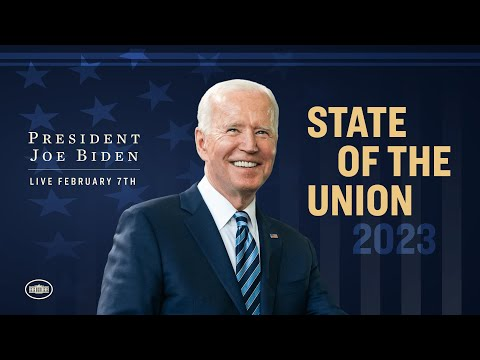

In [41]:
from IPython.display import YouTubeVideo
YouTubeVideo('gzcBTUvVp7M')

### The data

In [42]:
sotu = open('data/stateoftheunion1790-2023.txt').read()

In [43]:
len(sotu)

10577941

The entire **corpus** (another word for "set of documents") is over 10 million characters long... let's not display it in our notebook.

In [45]:
print(sotu[:1600])

The Project Gutenberg EBook of Complete State of the Union Addresses,
from 1790 to the Present. Speeches beginning in 2002 are from UCSB The American Presidency Project.
Speeches from 2018-2023 were manually downloaded from whitehouse.gov.

Character set encoding: UTF8

The addresses are separated by three asterisks


CONTENTS

  George Washington, State of the Union Address, January 8, 1790
  George Washington, State of the Union Address, December 8, 1790
  George Washington, State of the Union Address, October 25, 1791
  George Washington, State of the Union Address, November 6, 1792
  George Washington, State of the Union Address, December 3, 1793
  George Washington, State of the Union Address, November 19, 1794
  George Washington, State of the Union Address, December 8, 1795
  George Washington, State of the Union Address, December 7, 1796
  John Adams, State of the Union Address, November 22, 1797
  John Adams, State of the Union Address, December 8, 1798
  John Adams, State of 

Each speech is separated by `'***'`.

In [46]:
speeches = sotu.split('\n***\n')[1:]

In [47]:
len(speeches)

233

Note that each "speech" currently contains other information, like the name of the president and the date of the address.

In [48]:
print(speeches[-1][:1000])


State of the Union Address
Joseph R. Biden Jr.  
February 7, 2023

  Mr. Speaker. Madam Vice President. Our First Lady and Second
Gentleman. Members of Congress and the Cabinet. Leaders of our
military. Mr. Chief Justice, Associate Justices, and retired Justices
of the Supreme Court. And you, my fellow Americans.
  I start tonight by congratulating the members of the 118th Congress
and the new Speaker of the House, Kevin McCarthy. Mr. Speaker, I look
forward to working together.
  I also want to congratulate the new leader of the House Democrats and
the first Black House Minority Leader in history, Hakeem Jeffries.
  Congratulations to the longest serving Senate leader in history,
Mitch McConnell.
  And congratulations to Chuck Schumer for another term as Senate
Majority Leader, this time with an even bigger majority.
  And I want to give special recognition to someone who I think will be
considered the greatest Speaker in the history of this country, Nancy
Pelosi.
  The story of Amer

Let's extract just the speech text.

In [49]:
import re
def extract_struct(speech):
    L = speech.strip().split('\n', maxsplit=3)
    L[3] = re.sub(r"[^A-Za-z' ]", ' ', L[3]).lower()
    return dict(zip(['speech', 'president', 'date', 'contents'], L))

In [50]:
speeches_df = pd.DataFrame(list(map(extract_struct, speeches)))
speeches_df

,speech,president,date,contents
0,State of the Union Address,George Washington,"January 8, 1790",fellow citizens of the senate and house of re...
1,State of the Union Address,George Washington,"December 8, 1790",fellow citizens of the senate and house of re...
2,State of the Union Address,George Washington,"October 25, 1791",fellow citizens of the senate and house of re...
...,...,...,...,...
230,State of the Union Address,Joseph R. Biden Jr.,"April 28, 2021",thank you thank you thank you good to be b...
231,State of the Union Address,Joseph R. Biden Jr.,"March 1, 2022",madam speaker madam vice president and our ...
232,State of the Union Address,Joseph R. Biden Jr.,"February 7, 2023",mr speaker madam vice president our firs...


### Finding the most important words in each speech

Here, a "document" is a speech. We have 233 documents.

In [51]:
speeches_df.head()

,speech,president,date,contents
0,State of the Union Address,George Washington,"January 8, 1790",fellow citizens of the senate and house of re...
1,State of the Union Address,George Washington,"December 8, 1790",fellow citizens of the senate and house of re...
2,State of the Union Address,George Washington,"October 25, 1791",fellow citizens of the senate and house of re...
3,State of the Union Address,George Washington,"November 6, 1792",fellow citizens of the senate and house of re...
4,State of the Union Address,George Washington,"December 3, 1793",fellow citizens of the senate and house of re...


A rough sketch of what we'll compute:

```
for each word t:
    for each speech d:
        compute tfidf(t, d)
```

In [52]:
unique_words = pd.Series(speeches_df['contents'].str.split().sum()).value_counts()
# Take the top 500 most common words for speed
unique_words = unique_words.iloc[:500].index
unique_words

Index(['the', 'of', 'to', 'and', 'in', 'a', 'that', 'for', 'be', 'our',
       ...
       'desire', 'call', 'submitted', 'increasing', 'months', 'point', 'trust',
       'throughout', 'set', 'object'],
      dtype='object', length=500)

### 💡 Pro-Tip: Using `tqdm`

This code takes a while to run, so we'll use the `tdqm` package to track its progress. (Install with `pip install tqdm` if needed).

In [53]:
from tqdm.notebook import tqdm

tfidf_dict = {}
tf_denom = speeches_df['contents'].str.split().str.len()

# Wrap the sequence with `tqdm()` to display a progress bar
for word in tqdm(unique_words):
    re_pat = fr' {word} ' # Imperfect pattern for speed.
    tf = speeches_df['contents'].str.count(re_pat) / tf_denom
    idf = np.log(len(speeches_df) / speeches_df['contents'].str.contains(re_pat).sum())
    tfidf_dict[word] =  tf * idf

  0%|          | 0/500 [00:00<?, ?it/s]

In [54]:
tfidf = pd.DataFrame(tfidf_dict)
tfidf.head()

,the,of,to,and,...,trust,throughout,set,object
0,0.0,0.0,0.0,0.0,...,4.29e-04,0.00e+00,0.00e+00,2.04e-03
1,0.0,0.0,0.0,0.0,...,0.00e+00,0.00e+00,0.00e+00,1.06e-03
2,0.0,0.0,0.0,0.0,...,4.06e-04,0.00e+00,3.48e-04,6.44e-04
3,0.0,0.0,0.0,0.0,...,6.70e-04,2.17e-04,0.00e+00,7.09e-04
4,0.0,0.0,0.0,0.0,...,2.38e-04,4.62e-04,0.00e+00,3.77e-04


Note that the TF-IDFs of many common words are all 0!

### Summarizing speeches

By using `idxmax`, we can find the word with the highest TF-IDF in each speech.

In [55]:
summaries = tfidf.idxmax(axis=1)
summaries

0          object
1      convention
2       provision
          ...    
230          it's
231       tonight
232          it's
Length: 233, dtype: object

What if we want to see the 5 words with the highest TF-IDFs, for each speech?

In [56]:
def five_largest(row):
    return list(row.index[row.argsort()][-5:])

In [57]:
keywords = tfidf.apply(five_largest, axis=1)
keywords_df = pd.concat([
    speeches_df['president'],
    speeches_df['date'],
    keywords
], axis=1)

Run the cell below to see every single row of `keywords_df`.

In [58]:
display_df(keywords_df, rows=233)

,president,date,0
0,George Washington,"January 8, 1790","[your, proper, regard, ought, object]"
1,George Washington,"December 8, 1790","[case, established, object, commerce, convention]"
2,George Washington,"October 25, 1791","[community, upon, lands, proper, provision]"
3,George Washington,"November 6, 1792","[subject, upon, information, proper, provision]"
4,George Washington,"December 3, 1793","[having, vessels, executive, shall, ought]"
5,George Washington,"November 19, 1794","[too, army, let, ought, constitution]"
6,George Washington,"December 8, 1795","[army, prevent, object, provision, treaty]"
7,George Washington,"December 7, 1796","[republic, treaty, britain, ought, object]"
8,John Adams,"November 22, 1797","[spain, british, claims, treaty, vessels]"
9,John Adams,"December 8, 1798","[st, minister, treaty, spain, commerce]"


### Aside: What if we remove the $\log$ from $\text{idf}(t)$?

Let's try it and see what happens.

In [59]:
tfidf_nl_dict = {}
tf_denom = speeches_df['contents'].str.split().str.len()

for word in tqdm(unique_words):
    re_pat = fr' {word} ' # Imperfect pattern for speed.
    tf = speeches_df['contents'].str.count(re_pat) / tf_denom
    idf_nl = len(speeches_df) / speeches_df['contents'].str.contains(re_pat).sum()
    tfidf_nl_dict[word] =  tf * idf_nl

  0%|          | 0/500 [00:00<?, ?it/s]

In [60]:
tfidf_nl = pd.DataFrame(tfidf_nl_dict)
tfidf_nl.head()

,the,of,to,and,...,trust,throughout,set,object
0,0.09,0.06,0.05,0.04,...,1.47e-03,0.00e+00,0.00e+00,5.78e-03
1,0.09,0.06,0.03,0.03,...,0.00e+00,0.00e+00,0.00e+00,2.99e-03
2,0.11,0.07,0.04,0.03,...,1.39e-03,0.00e+00,1.30e-03,1.82e-03
3,0.09,0.07,0.04,0.03,...,2.29e-03,7.53e-04,0.00e+00,2.01e-03
4,0.09,0.07,0.04,0.02,...,8.12e-04,1.60e-03,0.00e+00,1.07e-03


In [61]:
keywords_nl = tfidf_nl.apply(five_largest, axis=1)
keywords_nl_df = pd.concat([
    speeches_df['president'],
    speeches_df['date'],
    keywords_nl
], axis=1)
keywords_nl_df

,president,date,0
0,George Washington,"January 8, 1790","[a, and, to, of, the]"
1,George Washington,"December 8, 1790","[in, and, to, of, the]"
2,George Washington,"October 25, 1791","[a, and, to, of, the]"
...,...,...,...
230,Joseph R. Biden Jr.,"April 28, 2021","[of, it's, and, to, the]"
231,Joseph R. Biden Jr.,"March 1, 2022","[we, of, to, and, the]"
232,Joseph R. Biden Jr.,"February 7, 2023","[a, of, and, to, the]"


### The role of $\log$ in $\text{idf}(t)$

$$
\begin{align*}\text{tfidf}(t, d) &= \text{tf}(t, d) \cdot \text{idf}(t) \\\ &= \frac{\text{# of occurrences of $t$ in $d$}}{\text{total # of words in $d$}} \cdot \log \left(\frac{\text{total # of documents}}{\text{# of documents in which $t$ appears}} \right) \end{align*} $$
- Remember, for any positive input $x$, $\log(x)$ is (much) smaller than $x$.
- In $\text{idf}(t)$, the $\log$ "dampens" the impact of the ratio $\frac{\text{# documents}}{\text{# documents with $t$}}$.

- If a word is very common, the ratio will be close to 1. The log of the ratio will be close to 0.

In [62]:
(1000 / 999)

1.001001001001001

In [63]:
np.log(1000 / 999)

0.001000500333583622

- If a word is very common (e.g. 'the'), removing the log multiplies the statistic by a large factor.
- If a word is very rare, the ratio will be very large. However, for instance, a word being seen in **2 out of 50** documents is not very different than being seen in **2 out of 500** documents (it is very rare in both cases), and so $\text{idf}(t)$ should be similar in both cases.

In [64]:
(50 / 2)

25.0

In [65]:
(500 / 2)

250.0

In [66]:
np.log(50 / 2)

3.2188758248682006

In [67]:
np.log(500 / 2)

5.521460917862246

## 🙋🙋🏽‍♀️ Questions?

https://app.sli.do/event/2LZSnXWNpGPiuVnCZMa5J8

<center><img src="imgs/slido.svg" width="30%"></center>

## Summary, next time

### Summary

- One way to turn documents, like `'deputy fire chief'`, into feature vectors, is to count the number of occurrences of each word in the document, ignoring order. This is done using the **bag of words** model.
- To measure the similarity of two documents under the bag of words model, compute the cosine similarity of their two word vectors.
- Term frequency-inverse document frequency (TF-IDF) is a statistic that tries to quantify how **important** a word (term) is to a document. It balances:
    - **how often a word appears in a particular document**, $\text{tf}(t, d)$, with
    - **how often a word appears across documents**, $\text{idf}(t)$.
- For a given document, the word with the highest TF-IDF is thought to "best summarize" that document.

### Next time

Modeling and feature engineering.